<br>
<p style="text-align: center;"><font size="4">Analysis</font></p>
<br>
<p style="text-align: center;"><font size="5">Mechanistic interactions as the origin of modularity in biological networks</font></p>
<br>
<p style="text-align: center;"><font size="3">March 2024</font></p>
<br>
<p style="text-align: center;"><font size="3">Daniel Wechsler & Jordi Bascompte</font></p>



# Set up

In [68]:
import sys

PATH = ''
PLOT_DIR = "plots/"
SUPPLEMENT_PLOT_DIR = "plots/supplement/"
DATA_DIR = "data/"
# If set to true the figures are saved in the directory PLOT_DIR
SAVE_FIGURES = True

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib.cm as cm
from matplotlib import ticker
import matplotlib as mpl
from io import StringIO  
import cmasher as cmr
import tabulate
import json

from core.finite_state_machine import *
from core.utilities import *
from core.modularity import *
from core.fsm_minimization import *
from core.basic_measures import *
from lib.plotting_helpers import *

pd.options.display.max_rows = 999
pd.set_option('max_colwidth', 250)
np.set_printoptions(linewidth=300)

In [69]:
mpl.rcParams['font.family'] = "serif"
mpl.rcParams['axes.labelsize'] = 14           
mpl.rcParams['axes.labelpad'] = 10.0   
plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.rcParams['figure.facecolor'] = 'white'

In [70]:
def countour_plot(df, x_col, y_col, z_col, levels, ax, ngridx = 50, ngridy = 50, num_ticks=5):

        
    x = df[x_col].tolist() 
    y = df[y_col].tolist()
    z = df[z_col].tolist()

    x_min = min(x)
    x_max = max(x)
    y_min = min(y)
    y_max = max(y)
    npts = len(z)
    complexity_min = min(z)
    complexity_max = max(z)

    ax1 = ax

    # Create grid values first.
    xi = np.linspace(x_min, x_max, ngridx)
    yi = np.linspace(y_min, y_max, ngridy)

    # Linearly interpolate the data (x, y) on a grid defined by (xi, yi).
    triang = tri.Triangulation(x, y)
    interpolator = tri.LinearTriInterpolator(triang, z)
    Xi, Yi = np.meshgrid(xi, yi)
    zi = interpolator(Xi, Yi)

    if not type(levels) is int:
        num_levels = len(levels)
    else:
        num_levels = levels + 1

    colors = getColorsFromColorMap(CONTOUR_COLOR_MAP, num_levels, min=0.2, max=0.2)
    cn = ax1.contour(xi, yi, zi, levels=levels, linewidths=0.2, colors='black')
    cntr1 = ax1.contourf(xi, yi, zi, levels=levels, colors=colors, alpha=0.9)
    
    axc = fig.colorbar(cntr1, ax=ax1)
    ax1.set(xlim=(x_min, x_max), ylim=(y_min, x_max))
    
    tick_locator = ticker.MaxNLocator(nbins=num_ticks)
    axc.locator = tick_locator
    axc.update_ticks()

    return axc


In [71]:
def linear_regression(df, independent, dependent, ax, linestyle='-', linewidth=2, color='black'):
    
    regr = linear_model.LinearRegression()
    data = np.array(list(df[independent])).reshape(-1, 1)
    regr.fit(data, df[dependent])
    y_pred = regr.predict(data)
    ax.plot(list(df[independent]), y_pred, color=color, linewidth=linewidth, linestyle=linestyle)
    results = smf.ols(dependent + ' ~ ' + independent, data=df).fit()
    p_value = results.pvalues[independent]  
    return p_value   

In [72]:
def print_data_summary(df):
    print("Details:")
    num_replicates = df.groupby(['NN', 'n', 'th']).count()['ID'].iloc[0]
    print("Num replicates: ", num_replicates)
    print("N: ", df['NN'].unique())
    print("n: ", df['n'].unique())
    print("th: ", df['th'].unique())
    print("FSM_COMPLEXITY_MAX_NO_IMPROVE: ", df['FSM_COMPLEXITY_MAX_NO_IMPROVE'].unique())
    print("NUM_RANDOMIZATIONS: ", df['NUM_RANDOMIZATIONS'].unique())
    print("MAX_MODULARITY_MAX_NO_IMPROVEMENT: ", df['MAX_MODULARITY_MAX_NO_IMPROVEMENT'].unique())
    print()
    print("Total Duration: ", round(df['DURATION'].sum() / 48 / 60 / 60, 3), "h")

In [73]:
DPI_JUPYTER = 80
DPI_FILE = 250
AXIS_LABEL_FONT_SIZE = 16

STD_PLOT_HEIGHT = 4
STD_PLOT_WIDTH = 4.5

IMG_FORMAT = 'eps'

In [74]:
LINE_COLOR_MAP = cmr.arctic  
CONTOUR_COLOR_MAP = 'jet' 

# Illustrations

## Figure 1

In [75]:
# Random seeds that lead to "good" fsm:
# 5, 47

seed = 47
np.random.seed(seed)
fsm_i, fsm_j = get_random_population(2, 3)

interact, out_i, out_j, pin_i, pin_j = fsm_i.encounter(fsm_j, return_cycle=True, return_pin=True)

print("pin i:  \t", pin_i)
print("pin j:  \t", pin_j)
print("cycle i:\t", out_i)  
print("cycle j:\t", out_j)
fsm_i.print_transition_table()
fsm_j.print_transition_table()
print("================================================")

pin i:  	 ['1', '1', '1']
pin j:  	 ['1', '0', '0']
cycle i:	 ['0', '1', '1']
cycle j:	 ['0', '0', '1']

S_t 	0	1	 Symbol
-------------------------------
0	2	0	 1
1	0	0	 0
2	1	1	 1

S_t 	0	1	 Symbol
-------------------------------
0	2	2	 1
1	1	0	 0
2	1	2	 0


## Figure 2

In [76]:
N = 60
n = 10
th = 1.0

In [77]:
# Function get_random_population expects legacy random generator which
# has method randint. This wrapper provides this function for new
# random generator
class RandomWrapper():
    
    def __init__(self, rg):
        self.rg = rg
    
    def randint(self, maximum):
        return self.rg.integers(maximum)


In [78]:
rng = np.random.default_rng(333)
rng_w = RandomWrapper(rng)
community = get_random_population(N, n, random_generator=rng_w)
G, cycles = compute_G(community, th=th, return_cycles=True)

In [80]:
if True:
    # Holds the output of the computation below (computing it takes long time)
    Q_stats_json = '{"Q": 0.25232248271209307, "groups": [0, 0, 7, 7, 7, 0, 0, 1, 0, 0, 8, 2, 7, 0, 7, 0, 7, 0, 0, 0, 8, 7, 7, 0, 3, 0, 8, 8, 8, 7, 0, 0, 3, 0, 7, 7, 0, 7, 7, 8, 0, 7, 0, 7, 8, 4, 7, 0, 0, 1, 7, 0, 0, 0, 5, 7, 6, 8, 7, 7], "p_value": 0.0, "z_score": 11.33886178094644, "Q_rand_samples": [0.12426041490976555, 0.11682914488109297, 0.1102243211334121, 0.12916174734356553, 0.12254680384550509, 0.1436903356383876, 0.10122786304604484, 0.11930173722381512, 0.150828132906055, 0.12198009782425366, 0.11892393320964749, 0.12213189407994607, 0.13148591668072185, 0.14081295328048576, 0.1412278630460449, 0.13288244223309156, 0.12258053634677012, 0.1206139315230225, 0.12409512565356724, 0.1229279811097993, 0.11893742621015344, 0.12139315230224323, 0.12301231236296176, 0.13368527576319789, 0.13660988362287066, 0.15754090065778378, 0.1312666554224996, 0.10894248608534324, 0.12802496205093605, 0.14265812109967957, 0.1297857986169674, 0.13122954967110811, 0.11079440040479001, 0.12858492157193457, 0.130325518637207, 0.10608871647832686, 0.13709900489121268, 0.11833698768763706, 0.11956485073368193, 0.12428065441052455, 0.12229718333614435, 0.1150413223140496, 0.1084230055658627, 0.11696407488615285, 0.12540394670264798, 0.11144881092933043, 0.11354022600775845, 0.12133918030021923, 0.11225839095968967, 0.12951593860684774, 0.12697588126159554, 0.13126328217237315, 0.11253499747006245, 0.12482037443076409, 0.14068814302580535, 0.11034238488783943, 0.11800978242536689, 0.1249047056839265, 0.1051104739416428, 0.13439365828976219, 0.13029853263619498, 0.124344746162928, 0.11840107944004052, 0.10773823579018382, 0.10812615955473098, 0.12579187046719514, 0.1251442064429077, 0.11456569404621349, 0.1355844155844156, 0.12489458593354698, 0.12679035250463824, 0.12297857986169679, 0.11525383707201886, 0.11986169674481369, 0.15515263956822398, 0.11577669084162595, 0.13010288412885812, 0.13334120425029516, 0.12480688143025803, 0.12861528082307305, 0.1312632821723731, 0.1338471917692697, 0.11638050261426885, 0.12446955641760837, 0.11488952605835726, 0.1315533816832518, 0.12829144881092935, 0.13478495530443585, 0.11818181818181817, 0.12652386574464497, 0.11455220104570754, 0.12423342890875358, 0.128126159554731, 0.12901332433799967, 0.1287468375780064, 0.12536684095125655, 0.11587788834542084, 0.13092258390959688, 0.13289930848372408, 0.1127913644796762, 0.12572777871479168, 0.1145049755439366, 0.13842469219092593, 0.11836397368864904, 0.13339180300219267, 0.1350750548153146, 0.1361342553550346, 0.12894923258559626, 0.11560465508517456, 0.1449924101872154, 0.10642266824085014, 0.13439365828976216, 0.13301737223815147, 0.13190419969640754, 0.1388564682071175, 0.12466857817507168, 0.1192174059706527, 0.09360094451003548, 0.13375611401585427, 0.1252858829482206, 0.12252656434474618, 0.12197335132400065, 0.13127677517287906, 0.13712599089222466, 0.11493000505987518, 0.1385427559453533, 0.11748018215550687, 0.13410018552875697, 0.14089728453364825, 0.1142553550345757, 0.11849890369370886, 0.13237645471411705, 0.13191769269691356, 0.1310271546635183, 0.12034744476302923, 0.10970484061393153, 0.12459436667228876, 0.1037578006409175, 0.11371563501433633, 0.12721538202057683, 0.11001855287569574, 0.13012987012987015, 0.1096373756114016, 0.13933884297520666, 0.12910777534154158, 0.13172879068982968, 0.14253668409512565, 0.12061055827289596, 0.13230898971158706, 0.13777702816663862, 0.11710575139146573, 0.12267498735031204, 0.10757631978411203, 0.11844155844155842, 0.13617473435655256, 0.13513240006746505, 0.11842469219092602, 0.12019564850733683, 0.11831000168662505, 0.12574464496542415, 0.11111485916680723, 0.11516950581885654, 0.1269657615112161, 0.136788665879575, 0.13141507842806543, 0.1354798448304942, 0.1140765727778715, 0.12034744476302918, 0.1349940968122786, 0.1036228706358576, 0.10584246921909259, 0.1421082813290606, 0.13331759149940967, 0.12458424692190925, 0.12100522853769606, 0.12188564682071175, 0.1211300387923765, 0.14196997807387415, 0.13145218417945692, 0.11612076235452858, 0.1135064935064935, 0.12247259234272224, 0.1380367684263788, 0.11500084331253164, 0.1078866587957497, 0.10492157193455898, 0.14223983808399393, 0.13929499072356213, 0.13137459942654744, 0.1350480688143025, 0.11707201889020069, 0.09821555068308321, 0.13693034238488783, 0.10386574464496541, 0.1362759318603475, 0.13421824928318435, 0.11038623713948387, 0.128085680553213, 0.13997638724911454, 0.12905717658964416, 0.13778040141676504, 0.1150446955641761, 0.12655759824590992, 0.11137797267667403, 0.1452892561983471, 0.10837915331421821, 0.13341878900320464, 0.12413223140495869, 0.11753752740765733, 0.12718502276943838, 0.128709731826615, 0.13843143869117902, 0.1350177095631641, 0.14373756114015854, 0.1318232416933716, 0.12891550008433128, 0.13291954798448305, 0.13308483724068138, 0.12983977061899138, 0.13475459605329732, 0.1426918536009445, 0.12102209478832855, 0.13160735368527576, 0.1260549839770619, 0.11775004216562662, 0.14649350649350645, 0.11077416090403105, 0.10755608028335303, 0.13194467869792545, 0.12794063079777365, 0.14596390622364647, 0.14882779558104234, 0.13646820711755775, 0.1498161578681059, 0.1273300725248777, 0.12670939450160235, 0.13822904368358913, 0.1308382526564345, 0.12164277281160399, 0.12772136953955138, 0.12378815989205609, 0.13969640748861528, 0.1112295496711081, 0.11797267667397537, 0.13444763029178614, 0.12095125653567211, 0.13920391297014673, 0.1481700118063754, 0.1176252319109462, 0.13770281666385564, 0.13571259908922245, 0.13737223815145894, 0.13754764715803677, 0.1359386068476977, 0.12350480688143028, 0.15831000168662507, 0.1252184179456907, 0.12077584752909437, 0.13323663349637377, 0.12807556080283355, 0.13568898633833698, 0.12039467026480015, 0.1235621521335807, 0.1423815145893068, 0.11404284027660655, 0.14001686625063248, 0.1440040479001518, 0.11756788665879575, 0.13029853263619495, 0.1286658795749705, 0.12835554056333276, 0.1269117895091921, 0.13279136447967618, 0.12504638218923936, 0.12170686456400742, 0.13000168662506326, 0.13556754933378312, 0.13583066284364986, 0.13609377635351663, 0.11629954461123296, 0.1283858998144712, 0.1154562320796087, 0.12568392646314722, 0.10924607859672797, 0.12484736043177608, 0.13310507674144045, 0.1456670602125148, 0.12795749704840614, 0.122654747849553, 0.0974329566537359, 0.13146567717996285, 0.10925619834710747, 0.10211165457918703, 0.10889863383369877, 0.12424017540900661, 0.14079946027997983, 0.09661325687299711, 0.13867768595041327, 0.1067532467532468, 0.14420306965761515, 0.1123528419632316, 0.14663855624894587, 0.11992916174734355, 0.12448642266824089, 0.11616124135604661, 0.13719345589475462, 0.1207893405296003, 0.1285579355709226, 0.10922921234609545, 0.14060718502276945, 0.12330241187384042, 0.1186169674481364, 0.12863214707370557, 0.12312025636700968, 0.13001180637544274, 0.1517962556923596, 0.11434643278799124, 0.12297857986169675, 0.12212852082981954, 0.1253533479507505, 0.13000843312531624, 0.12160229381008605, 0.12099510878731659, 0.11304435823916345, 0.13854275594535337, 0.09779389441727106, 0.11353010625737903, 0.13773992241524707, 0.13921740597065277, 0.1347984483049418, 0.11793894417271039, 0.1418552875695733, 0.11706189913982121, 0.12571091246415925, 0.11709225839095966, 0.1274751222803171, 0.12317422836903358, 0.12456400742115029, 0.12623376623376625, 0.144854106932029, 0.12697250801146903, 0.12232079608702986, 0.12810929330409854, 0.1522583909596897, 0.13420812953280492, 0.09766571091246415, 0.11731826614943497, 0.11849215719345592, 0.12157530780907404, 0.11962556923595885, 0.12095462978579861, 0.12700286726260757, 0.1152201045707539, 0.12106257378984657, 0.12350143363130378, 0.14000674650025297, 0.10734019227525718, 0.1328891887333446, 0.12004385225164449, 0.12726260752234778, 0.12559284870973184, 0.13241018721538203, 0.1330376117389105, 0.11564850733681906, 0.11732501264968802, 0.13459605329735197, 0.12116714454376792, 0.10637881598920564, 0.13634002361275088, 0.12735031202563665, 0.11717996289424863, 0.11532467532467533, 0.12112666554224993, 0.12511722044189577, 0.12655085174565694, 0.1226210153482881, 0.1345994265474785, 0.12547141170517795, 0.12851408331927813, 0.1284432450666217, 0.13082138640580201, 0.11998313374936748, 0.14444931691684942, 0.12760330578512394, 0.11332433799966266, 0.12336650362624396, 0.12296846011131723, 0.11953786473266992, 0.10908753584078257, 0.12680047225501775, 0.13820543093270363, 0.11611738910440211, 0.12093776353516614, 0.13885984145724412, 0.1488041828301569, 0.13541575307809076, 0.11963906223646487, 0.12042165626581208, 0.13045032889188735, 0.1412076235452859, 0.12075560802833532, 0.12729971327373923, 0.13028503963568902, 0.13226513745994262, 0.14658795749704848, 0.12499578343734188, 0.11943329397874852, 0.13618485410693207, 0.11679541237982795, 0.1362421993590825, 0.12753246753246752, 0.12083656603137119, 0.13185697419463657, 0.12145724405464664, 0.14129532804857484, 0.11119581716984314, 0.13312531624219937, 0.13161410018552877, 0.11731826614943497, 0.11712936414235116, 0.12762017203575649, 0.14146736380502617, 0.1286017878225671, 0.12730645977399224, 0.12352841963231574, 0.11942654747849554, 0.13153988868274583, 0.12071175577669087, 0.13579018384213196, 0.12473604317760163, 0.13848541069320291, 0.1346905043008939, 0.09571934558947545, 0.12146399055489965, 0.15594198009782428, 0.13107438016528924, 0.12945522010457075, 0.15133749367515606, 0.12417271040647666, 0.1363939956147749, 0.13059537864732668, 0.13984483049418114, 0.12504975543936583, 0.14047562826783605, 0.13669421487603306, 0.11806375442739082, 0.10945184685444424, 0.1222971833361444, 0.13219429920728618, 0.11797267667397539, 0.12304604486422668, 0.13583066284364986, 0.13930511047394162, 0.14034407151290265, 0.132416933715635, 0.12881767583066284, 0.13328723224827121, 0.15169168493843818, 0.13028166638556252, 0.11945690672963398, 0.1452555236970821, 0.12246921909259575, 0.12863214707370552, 0.12062405127340191, 0.13734862540057347, 0.12652049249451852, 0.12803845505144207, 0.10590318772136964, 0.1442131894079946, 0.11520661157024793, 0.11484230055658629, 0.13075729465339853, 0.1109765559116209, 0.1200809580030359, 0.12201383032551864, 0.13243717321639398, 0.14387586439534492, 0.12652049249451847, 0.14517456569404621, 0.11920728622027325, 0.12717827626918543, 0.12614268848035082, 0.12696913476134258, 0.13012312362961714, 0.11726429414741105, 0.11598583234946869, 0.10823747680890536, 0.10860853432282006, 0.11801990217574634, 0.14453364817001182, 0.13617136110642605, 0.12665542249957834, 0.12138303255186374, 0.11031539888682748, 0.12644628099173555, 0.11779389441727106, 0.1329836397368865, 0.10572103221453868, 0.12511722044189577, 0.12547815820543093], "Q_rand": 0.12616166638556248, "Q_max": 0.40038117726429423, "Q_norm": 0.46007235561849846, "Q_maximizer": null}'
    Q_stats = json.loads(Q_stats_json)
else:
    
    # Use this to recalculate the values.
    Q_stats = cacl_modularity_unipartite(G, modularity_function=cacl_modularity_unipartite, NUM_RANDOMIZATIONS=500, RETURN_NORMALIZED=True, MAX_NO_IMPROVEMENT=20000)
   

In [81]:
Q = Q_stats['Q'] # Raw value of modularity
Q_rand = Q_stats['Q_rand']  # Expected modularity of a random network (same size and connectance as G)
Q_max = Q_stats['Q_max'] # Maximum modularity of a network with same size and connectance as G
Q_norm = Q_stats['Q_norm'] # Normalized modularity (eq. 1)
Q_p_value = Q_stats['p_value'] # P-value of modularity
Q_rand_samples = Q_stats['Q_rand_samples']
groups = Q_stats['groups']

print('Q', Q)
print('Q_rand', Q_rand)
print('Q_max', Q_max)
print('Q_norm', Q_norm)
alpha = 0.05
significance_threshold = min(sorted(Q_rand_samples)[-int(len(Q_rand_samples) * alpha):])

Q 0.25232248271209307
Q_rand 0.12616166638556248
Q_max 0.40038117726429423
Q_norm 0.46007235561849846


In [82]:
modules, cnt = np.unique(groups, return_counts=True)

In [83]:
modules

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [84]:
cnt

array([24,  2,  1,  2,  1,  1,  1, 20,  8])

In [85]:
modules_sorted = [module for module, _ in sorted(zip(modules, cnt), key=lambda pair: pair[1], reverse=True)]
modules_sorted

[0, 7, 8, 1, 3, 2, 4, 5, 6]

In [86]:
new_order_nodes = []
new_order_modules = []

for module in modules_sorted:
    for i, groups_i in enumerate(groups):
        if module == groups_i: 
            new_order_nodes.append(i)
            new_order_modules.append(module)
        
G_sorted = G[new_order_nodes, :]
G_sorted = G_sorted[:,new_order_nodes]

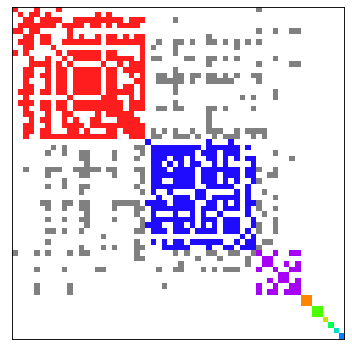

In [87]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=False, squeeze=False, figsize=(STD_PLOT_WIDTH, STD_PLOT_WIDTH), dpi=DPI_JUPYTER)

plot_binary_matrix(G_sorted, ax=ax[0,0], x_group=new_order_modules, y_group=new_order_modules, colormap='hsv')

fig.tight_layout()

if SAVE_FIGURES:
    fig.savefig(PATH + PLOT_DIR + "Figure_2A." + IMG_FORMAT, dpi=DPI_FILE)

plt.show()

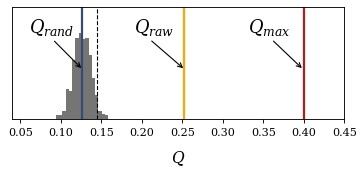

In [88]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=False, squeeze=False, figsize=(STD_PLOT_WIDTH, 2.3), dpi=DPI_JUPYTER)

ax[0,0].set_xlabel("Q", fontsize=14)
margin = (Q_max - min(Q_rand_samples)) * 0.05
ax[0,0].set_xlim(min(Q_rand_samples)-margin, max(Q_max, max(Q_rand_samples))+margin)

ax[0,0].hist(Q_rand_samples, bins=16, density=True, color = '#757575')

ax[0,0].axvline(Q_max, color='#b81a1f', linewidth=2)
ax[0,0].axvline(Q_rand, color='#304d75', linewidth=2)
ax[0,0].axvline(Q, color='orange', linewidth=2)
ax[0,0].axvline(significance_threshold, color='black', linewidth=1.0, linestyle='--')
ax[0,0].set_ylim(0.15, 45)
ax[0,0].set_xlim(0.04, 0.45)

ax[0,0].set_xlabel('$Q$')   

ax[0,0].text(0.06, 35, '$Q_{rand}$', fontsize = 16)
ax[0,0].annotate(xy=(0.09, 32), xytext=(0.127, 20), arrowprops=dict(arrowstyle='<-'), text='')

ax[0,0].text(0.19, 35, '$Q_{raw}$', fontsize = 16)
ax[0,0].annotate(xy=(0.21, 32), xytext=(0.253, 20), arrowprops=dict(arrowstyle='<-'), text='')

ax[0,0].text(Q_max-0.07, 35, '$Q_{max}$', fontsize = 16)
ax[0,0].annotate(xy=(Q_max-0.04, 32), xytext=(Q_max-0.001, 20), arrowprops=dict(arrowstyle='<-'), text='')


ax[0,0].yaxis.set_tick_params(labelleft=False)

ax[0,0].set_yticks([])

fig.tight_layout()

if SAVE_FIGURES:
    fig.savefig(PATH + PLOT_DIR + "Figure_2B." + IMG_FORMAT, dpi=DPI_FILE)
    
plt.show()

<br>

# Experiment I: Random Assemblages

<br>

In [89]:
def line_plot(ax, df, x, y, z, z_values, th=1.0, z_label=None, show_error_bars=None):
    """
    General function for the line plots.
    x := column name for x-axis
    y := column name for y-axis
    z := column name for which to group by (i.e. draw multiple lines)
    z_values := the values of z for which to draw lines
    """
    
    SHOW_ERROR_BARS = False
    if not show_error_bars is None:
        SHOW_ERROR_BARS = show_error_bars
        
    if z_label is None:
        z_label = z
        
    colors = getColorsFromColorMap (LINE_COLOR_MAP, len(z_values), min=0.1, max=0.0)

    for i, z_value_i in enumerate(z_values):
        
        df_tmp = df[(df[z] == z_value_i) & (df['th'] == th)]  
        
        df_mean = df_tmp.groupby([x], as_index=False).mean(numeric_only=True)
        df_mean.plot(x=x, y=y, ax=ax, linewidth=2.5, label=z_label +'=' + str(z_value_i), color=colors[i], marker='.', alpha=0.9)

        if SHOW_ERROR_BARS:
            error = df_tmp.groupby([x], as_index=False).std()[y].tolist()
            ax.errorbar(df_mean[x], df_mean[y], error, linestyle='None',  fmt='k', color=ERROR_BAR_COLOR,
                     ecolor='grey', elinewidth=0.3, capsize=2)


In [90]:
df_ps = pd.read_csv(DATA_DIR + "/random_assemblages_modularity.csv", index_col=0)
print_data_summary(df_ps)

Details:
Num replicates:  150
N:  [ 20  40  60  80 100 120 140 160 180]
n:  [10 15 20 25 30 35 40 45 50]
th:  [0.5  0.75 1.  ]
FSM_COMPLEXITY_MAX_NO_IMPROVE:  [0]
NUM_RANDOMIZATIONS:  [500]
MAX_MODULARITY_MAX_NO_IMPROVEMENT:  [20000]

Total Duration:  366.951 h


In [91]:
df_complexity_N = pd.read_csv(DATA_DIR + "/random_assemblages_complexity_NN.csv", index_col=0)
print_data_summary(df_complexity_N)

Details:
Num replicates:  20
N:  [ 20  40  60  80 100 120 140 160 180]
n:  [20 30 40]
th:  [0.5  0.75 1.  ]
FSM_COMPLEXITY_MAX_NO_IMPROVE:  [2000000]
NUM_RANDOMIZATIONS:  [0]
MAX_MODULARITY_MAX_NO_IMPROVEMENT:  [0]

Total Duration:  297.629 h


In [92]:
df_complexity_n = pd.read_csv(DATA_DIR + "/random_assemblages_complexity_n.csv", index_col=0)
print_data_summary(df_complexity_n)

Details:
Num replicates:  20
N:  [ 40  80 120]
n:  [10 15 20 25 30 35 40 45 50]
th:  [0.5  0.75 1.  ]
FSM_COMPLEXITY_MAX_NO_IMPROVE:  [2000000]
NUM_RANDOMIZATIONS:  [0]
MAX_MODULARITY_MAX_NO_IMPROVEMENT:  [0]

Total Duration:  184.958 h


In [93]:
# Define globaly the N and n values shown in the plots
N_VALUES = [40, 80, 120]
n_VALUES = [20, 30, 40]
SHOW_ERROR_BARS = True

ERROR_BAR_COLOR = '#292928'

## Figure 3 - N and n versus modularity

In [94]:
th = 1.0
df_ps_sub = pd.DataFrame(df_ps[df_ps['th'] == th])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


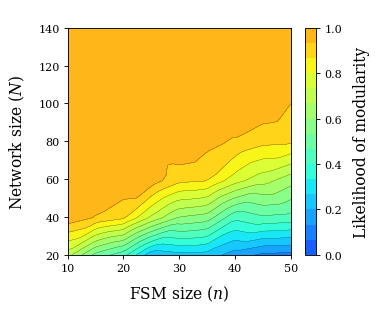

In [95]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=False, squeeze=False, figsize=(4.8, STD_PLOT_HEIGHT), dpi=DPI_JUPYTER) 

#########################################
# MODULARITY SIGNIFICANCE
#########################################
df_tmp = df_ps_sub.groupby(['NN', 'n'], as_index=False).mean(numeric_only=True)

axc = countour_plot(df_tmp, 'n', 'NN', 'modularity_significant', levels=np.linspace(0.0, 1, 16), ax=ax[0,0])

ax[0,0].set_ylim((20, 140))
ax[0,0].set_ylabel('Network size ($N$)')
ax[0,0].set_xlabel('FSM size ($n$)')
axc.set_label('Likelihood of modularity')
ax[0,0].set_title(" ", fontsize=16)

fig.tight_layout()

if SAVE_FIGURES:
    fig.savefig(PATH + PLOT_DIR + "Figure_3A." + IMG_FORMAT, dpi=DPI_FILE)
    
plt.show()  

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


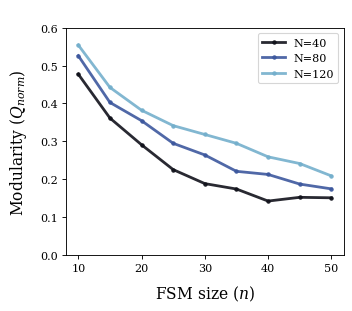

In [96]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=False, squeeze=False, figsize=(STD_PLOT_WIDTH, STD_PLOT_HEIGHT), dpi=DPI_JUPYTER) 

#########################################
# MODULARITY VS n
#########################################

line_plot(ax[0,0], df_ps, x='n', y='Q_norm', z='NN', z_values=N_VALUES, th=1.0, z_label='N')

ax[0,0].set_ylabel('Modularity ($Q_{norm}$)')   
ax[0,0].set_xlabel('FSM size ($n$)')
ax[0,0].set_title(" ", fontsize=16)
ax[0,0].set_ylim(0, 0.6)

fig.tight_layout()

if SAVE_FIGURES:
    fig.savefig(PATH + PLOT_DIR + "Figure_3B." + IMG_FORMAT, dpi=DPI_FILE)
    
plt.show()  

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


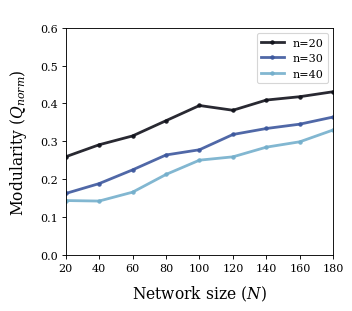

In [97]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=False, squeeze=False, figsize=(STD_PLOT_WIDTH, STD_PLOT_HEIGHT), dpi=DPI_JUPYTER) 

#########################################
# MODULARITY VS N
#########################################    

line_plot(ax[0,0], df_ps, x='NN', y='Q_norm', z='n', z_values=n_VALUES, th=1.0)  
   
ax[0,0].set_xlim((20, 180))
ax[0,0].set_xlabel('Network size ($N$)')
ax[0,0].set_ylabel('Modularity ($Q_{norm}$)')   
ax[0,0].set_title(" ", fontsize=16)
ax[0,0].set_ylim(0, 0.6)

fig.tight_layout()

if SAVE_FIGURES:
    fig.savefig(PATH + PLOT_DIR + "Figure_3C." + IMG_FORMAT, dpi=DPI_FILE)
    
plt.show()  

## Figure 4 A - N vs trait complexity

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


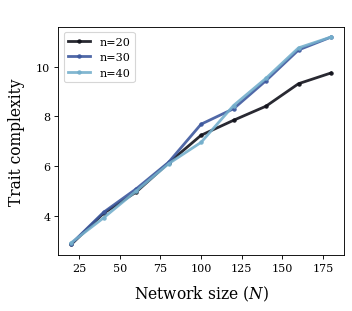

In [98]:
#########################################
# Trait complexity VS N
#########################################    

fig, ax = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=False, squeeze=False, figsize=(STD_PLOT_WIDTH, STD_PLOT_HEIGHT), dpi=DPI_JUPYTER) 

line_plot(ax[0,0], df_complexity_N, x='NN', y='mean_rel_complexity', z='n', z_values=n_VALUES, th=1.0)  

ax[0,0].set_xlabel('Network size ($N$)')
ax[0,0].set_ylabel('Trait complexity')   
ax[0,0].set_title(" ", fontsize=15)

fig.tight_layout()

if SAVE_FIGURES:
    fig.savefig(PATH + PLOT_DIR + "Figure_4A." + IMG_FORMAT, dpi=DPI_FILE)
    
plt.show()   

## Figure 4 B - n vs trait complexity

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


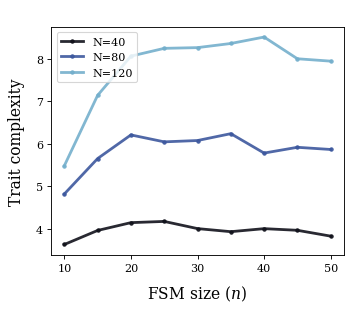

In [99]:
#########################################
# Trait complexity VS n
#########################################

fig, ax = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=False, squeeze=False, figsize=(STD_PLOT_WIDTH, STD_PLOT_HEIGHT), dpi=DPI_JUPYTER) 

line_plot(ax[0,0], df_complexity_n, x='n', y='mean_rel_complexity', z='NN', z_values=N_VALUES, th=1.0, z_label='N')  

ax[0,0].set_ylabel('Trait complexity')   
ax[0,0].set_xlabel('FSM size ($n$)')
ax[0,0].set_title(" ", fontsize=15)

fig.tight_layout()

if SAVE_FIGURES:
    fig.savefig(PATH + PLOT_DIR + "Figure_4B." + IMG_FORMAT, dpi=DPI_FILE)
    
plt.show()   

## Figure S1 - N and n vs connectance

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


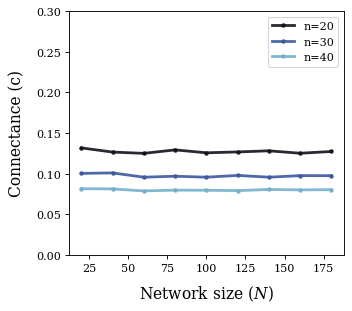

In [100]:
#########################################
# Connectance vs n and N
#########################################

fig, ax = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=False, squeeze=False, figsize=(STD_PLOT_WIDTH, STD_PLOT_HEIGHT), dpi=DPI_JUPYTER)

line_plot(ax[0,0], df_ps, x='NN', y='c', z='n', z_values=n_VALUES, th=1.0, z_label='n', show_error_bars=False)  

ax[0,0].set_ylabel('Connectance (c)')     
ax[0,0].set_xlabel("Network size ($N$)")
ax[0,0].set_ylim(0.0, 0.3)

fig.tight_layout()

if SAVE_FIGURES:
    fig.savefig(PATH + SUPPLEMENT_PLOT_DIR + "ESM_unipartite_connectance_vs_N." + IMG_FORMAT, dpi=DPI_FILE)
plt.show()   

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


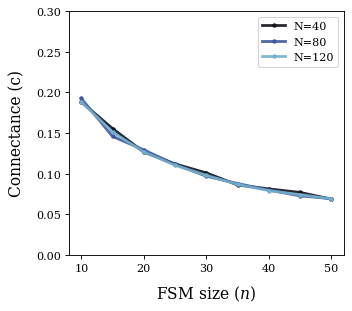

In [101]:
#########################################
# Connectance vs n and N
#########################################

fig, ax = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=False, squeeze=False, figsize=(STD_PLOT_WIDTH, STD_PLOT_HEIGHT), dpi=DPI_JUPYTER)

line_plot(ax[0,0], df_ps, x='n', y='c', z='NN', z_values=N_VALUES, th=1.0, z_label='N')  

ax[0,0].set_ylabel('Connectance (c)')    
ax[0,0].set_xlabel("FSM size ($n$)")
ax[0,0].set_ylim(0.0, 0.3)

fig.tight_layout()

if SAVE_FIGURES:
    fig.savefig(PATH + SUPPLEMENT_PLOT_DIR + "ESM_unipartite_connectance_vs_n." + IMG_FORMAT, dpi=DPI_FILE)
    
plt.show()   

## Figure S2 - Effect of specificity on connectance (c)

In [102]:
N = 80

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


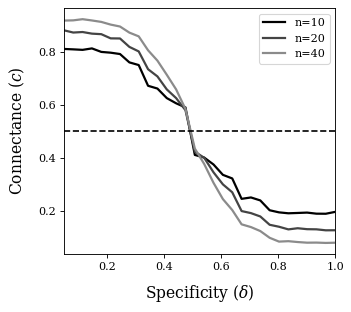

In [103]:
df_th = pd.read_csv(DATA_DIR + "specificity_vs_connectance.csv", index_col=0)
df_th = pd.DataFrame(df_th[df_th['n'] > 5])
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=False, squeeze=False, figsize=(STD_PLOT_WIDTH, STD_PLOT_HEIGHT), dpi=DPI_JUPYTER) 

colors = getColorsFromColorMap ('bone', len(df_th['n'].unique()), min=0.0, max=0.0)
colors = ['#000000', '#444444', '#8b8b8b']

for i, n in enumerate(df_th['n'].unique()):
    df_tmp = df_th[df_th['n'] == n]
    df_tmp.groupby(['th'], as_index=False).mean().plot(x='th', y='c', ax=ax[0,0], linewidth=2, label='n=' + str(int(n)), color=colors[i])

ax[0,0].set_xlabel("Specificity ($\delta$)")
ax[0,0].set_ylabel("Connectance ($c$)")
    
ax[0,0].axhline(0.5, linestyle='--', color='black')
ax[0,0].set_xlim(0.05,1)
fig.tight_layout()

if SAVE_FIGURES:
    fig.savefig(PATH + SUPPLEMENT_PLOT_DIR + "ESM_unipartite_connectance_vs_th_detail." + IMG_FORMAT, dpi=DPI_FILE)

plt.show() 

## Figure S3 - Effect of specificity on modularity significance

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


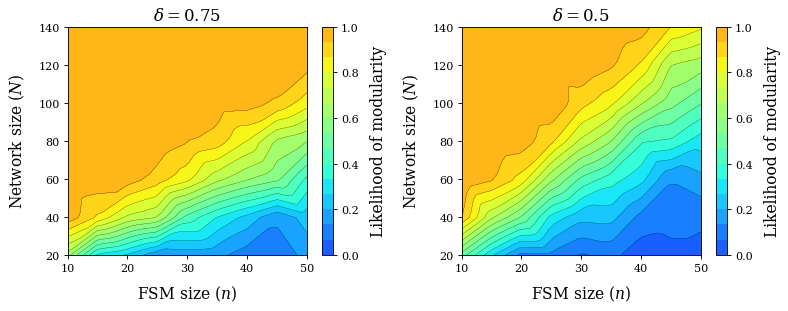

In [104]:
#########################################
# Replicate of Figure 3 A
#########################################

fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, squeeze=False, figsize=(10, STD_PLOT_HEIGHT), dpi=DPI_JUPYTER) 

#########################################
# MODULARITY SIGNIFICANCE (TH=0.75)
#########################################
th = 0.75
df_ps_sub = pd.DataFrame(df_ps[df_ps['th'] == th])
df_tmp = df_ps_sub.groupby(['NN', 'n'], as_index=False).mean(numeric_only=True)
axc = countour_plot(df_tmp, 'n', 'NN', 'modularity_significant', levels=np.linspace(0, 1, 16), ax=ax[0,0])
    
ax[0,0].set_ylim((20, 140))
ax[0,0].set_ylabel('Network size ($N$)')
ax[0,0].set_xlabel('FSM size ($n$)')
axc.set_label('Likelihood of modularity')
ax[0,0].set_title("$\delta=" + str(th) + "$", fontsize=15)

#########################################
# MODULARITY SIGNIFICANCE (TH=0.5)
#########################################
th = 0.5
df_ps_sub = pd.DataFrame(df_ps[df_ps['th'] == th])
df_tmp = df_ps_sub.groupby(['NN', 'n'], as_index=False).mean(numeric_only=True)
axc = countour_plot(df_tmp, 'n', 'NN', 'modularity_significant', levels=np.linspace(0, 1, 16), ax=ax[0,1])
    
ax[0,1].set_ylim((20, 140))
ax[0,1].set_ylabel('Network size ($N$)')
ax[0,1].set_xlabel('FSM size ($n$)')
axc.set_label('Likelihood of modularity')
ax[0,1].set_title("$\delta=" + str(th) + "$", fontsize=15)

fig.tight_layout()

if SAVE_FIGURES:
    fig.savefig(PATH + SUPPLEMENT_PLOT_DIR + "ESM_unipartite_modularity_significance_th." + IMG_FORMAT, dpi=DPI_FILE)
    
plt.show() 

## Figure S4 - Effect of specificity on relationship between n and modularity

In [105]:
PLOT_HEIGHT = 3.6

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


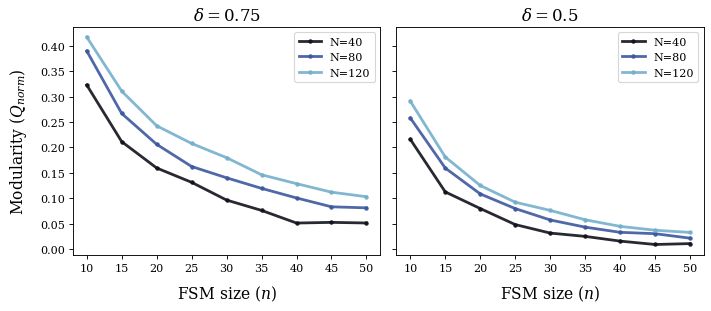

In [106]:
#########################################
# Replicate of Figure 3 B
#########################################

fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True, squeeze=False, figsize=(STD_PLOT_WIDTH*2, STD_PLOT_HEIGHT), dpi=DPI_JUPYTER)

#########################################
# MODULARITY VS n (TH=0.75)
#########################################

th = 0.75
line_plot(ax[0,0], df_ps, x='n', y='Q_norm', z='NN', z_values=N_VALUES, th=th, z_label='N')  

ax[0,0].set_ylabel('Modularity ($Q_{norm}$)')
ax[0,0].set_xlabel('FSM size ($n$)')
ax[0,0].set_title("$\delta=" + str(th) + "$", fontsize=15)    
    
#########################################
# MODULARITY VS n (TH=0.5)
#########################################    

th = 0.5
line_plot(ax[0,1], df_ps, x='n', y='Q_norm', z='NN', z_values=N_VALUES, th=th, z_label='N')  

ax[0,1].set_ylabel('Modularity ($Q_{norm}$)')
ax[0,1].set_xlabel('FSM size ($n$)')
ax[0,1].set_title("$\delta=" + str(th) + "$", fontsize=15)  
    

fig.tight_layout()

if SAVE_FIGURES:
    fig.savefig(PATH + SUPPLEMENT_PLOT_DIR + "ESM_unipartite_modularity_n_th." + IMG_FORMAT, dpi=DPI_FILE)
plt.show()   

## Figure S5 - Effect of specificity on relationship between N and modularity

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


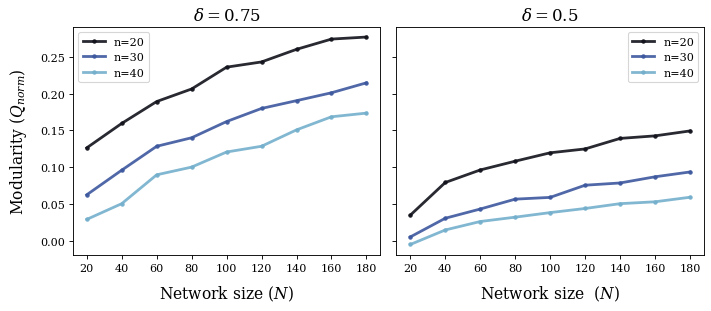

In [107]:
#########################################
# Replicate of Figure 3 C
#########################################

fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True, squeeze=False, figsize=(STD_PLOT_WIDTH*2, STD_PLOT_HEIGHT), dpi=DPI_JUPYTER)

#########################################
# MODULARITY VS N (TH=0.75)
#########################################

th = 0.75
line_plot(ax[0,0], df_ps, x='NN', y='Q_norm', z='n', z_values=n_VALUES, th=th)  

ax[0,0].set_ylabel('Modularity ($Q_{norm}$)')
ax[0,0].set_xlabel('Network size ($N$)')
ax[0,0].set_title("$\delta=" + str(th) + "$", fontsize=15)    
    
#########################################
# MODULARITY VS N (TH=0.5)
#########################################    

th = 0.5
line_plot(ax[0,1], df_ps, x='NN', y='Q_norm', z='n', z_values=n_VALUES, th=th)  

ax[0,1].set_ylabel('Modularity ($Q_{norm}$')
ax[0,1].set_xlabel('Network size  ($N$)')
ax[0,1].set_title("$\delta=" + str(th) + "$", fontsize=15)  
    

fig.tight_layout()

if SAVE_FIGURES:
    fig.savefig(PATH + SUPPLEMENT_PLOT_DIR + "ESM_unipartite_modularity_N_th." + IMG_FORMAT, dpi=DPI_FILE)
    
plt.show() 

## Figure S6 - Effect of specificity on relationship between N and trait complexity

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


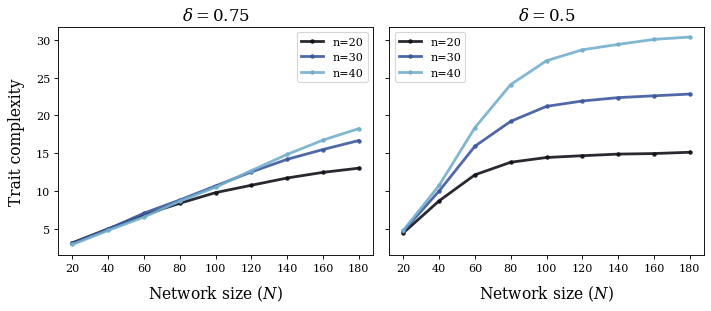

In [108]:
#########################################
# Replicate of Figure 4 A
#########################################

fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True, squeeze=False, figsize=(STD_PLOT_WIDTH*2, STD_PLOT_HEIGHT), dpi=DPI_JUPYTER)

#########################################
# COMPLEXITY VS N (TH=0.75)
#########################################

th = 0.75
line_plot(ax[0,0], df_complexity_N, x='NN', y='mean_rel_complexity', z='n', z_values=n_VALUES, th=th)  

ax[0,0].set_xlabel('Network size ($N$)')
ax[0,0].set_ylabel('Trait complexity')   
ax[0,0].set_title("$\delta=" + str(th) + "$", fontsize=15)

#########################################
# MODULARITY VS N (TH=0.5)
#########################################    

th = 0.5
line_plot(ax[0,1], df_complexity_N, x='NN', y='mean_rel_complexity', z='n', z_values=n_VALUES, th=th) 

ax[0,1].set_xlabel('Network size ($N$)')
ax[0,1].set_ylabel('Trait complexity')   
ax[0,1].set_title("$\delta=" + str(th) + "$", fontsize=15) 
    
fig.tight_layout()

if SAVE_FIGURES:
    fig.savefig(PATH + SUPPLEMENT_PLOT_DIR + "ESM_unipartite_complexity_N_th." + IMG_FORMAT, dpi=DPI_FILE)
    
plt.show() 

## Figure S7 - Effect of specificity on relationship between n and trait complexity

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


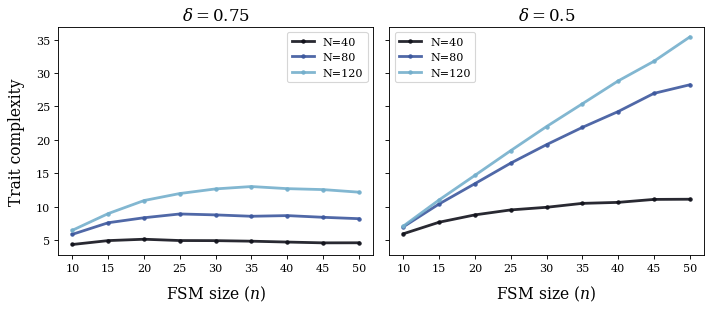

In [109]:
#########################################
# Replicate of Figure 4 B
#########################################

fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True, squeeze=False, figsize=(STD_PLOT_WIDTH*2, STD_PLOT_HEIGHT), dpi=DPI_JUPYTER)

#########################################
# COMPLEXITY VS N (TH=0.75)
#########################################

th = 0.75
line_plot(ax[0,0], df_complexity_n, x='n', y='mean_rel_complexity', z='NN', z_values=N_VALUES, th=th, z_label='N')  

ax[0,0].set_xlabel('FSM size ($n$)')
ax[0,0].set_ylabel('Trait complexity')   
ax[0,0].set_title("$\delta=" + str(th) + "$", fontsize=15)

#########################################
# MODULARITY VS N (TH=0.5)
#########################################    

th = 0.5
line_plot(ax[0,1], df_complexity_n, x='n', y='mean_rel_complexity', z='NN', z_values=N_VALUES, th=th, z_label='N') 

ax[0,1].set_xlabel('FSM size ($n$)')
ax[0,1].set_ylabel('Trait complexity')   
ax[0,1].set_title("$\delta=" + str(th) + "$", fontsize=15) 
    
fig.tight_layout()

if SAVE_FIGURES:
    fig.savefig(PATH + SUPPLEMENT_PLOT_DIR + "ESM_unipartite_complexity_n_th." + IMG_FORMAT, dpi=DPI_FILE)
    
plt.show() 

## Figure S8 - Effect of specificity on relationshp between n and connectance

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


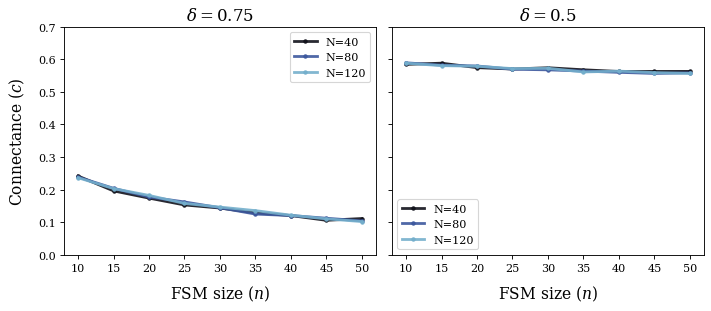

In [110]:
#########################################
# Replicate of Figure 
#########################################

fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True, squeeze=False, figsize=(STD_PLOT_WIDTH*2, STD_PLOT_HEIGHT), dpi=DPI_JUPYTER)

#########################################
# COMPLEXITY VS N (TH=0.75)
#########################################

th = 0.75
line_plot(ax[0,0], df_complexity_n, x='n', y='c', z='NN', z_values=N_VALUES, th=th, z_label='N')  

ax[0,0].set_xlabel('FSM size ($n$)')
ax[0,0].set_ylabel('Connectance ($c$)')   
ax[0,0].set_title("$\delta=" + str(th) + "$", fontsize=15)
ax[0,0].set_ylim(0,0.7)

#########################################
# MODULARITY VS N (TH=0.5)
#########################################    

th = 0.5
line_plot(ax[0,1], df_complexity_n, x='n', y='c', z='NN', z_values=N_VALUES, th=th, z_label='N') 

ax[0,1].set_xlabel('FSM size ($n$)')
ax[0,1].set_ylabel('Connectance ($c$)')   
ax[0,1].set_title("$\delta=" + str(th) + "$", fontsize=15) 
ax[0,1].set_ylim(0,0.7)

fig.tight_layout()

if SAVE_FIGURES:
    fig.savefig(PATH + SUPPLEMENT_PLOT_DIR + "ESM_unipartite_connectance_n_th." + IMG_FORMAT, dpi=DPI_FILE)
plt.show() 

<br>

# Experiment II: Modularty vs. Complexity

<br>

## Figure 5 - Modularity, connectance and N vs complexity

In [111]:
df_all = pd.read_csv(DATA_DIR + "opt_modularity_c.csv", index_col=0)
print_data_summary(df_all)

Details:
Num replicates:  420
N:  [40]
n:  [20]
th:  [0.5  0.75 1.  ]
FSM_COMPLEXITY_MAX_NO_IMPROVE:  [2000000]
NUM_RANDOMIZATIONS:  [500]
MAX_MODULARITY_MAX_NO_IMPROVEMENT:  [20000]

Total Duration:  31.522 h


In [112]:
print("Parameter Space Scan:")
num_replicates = df_all.groupby(['NN', 'n', 'th', 'c_target', 'Q_target']).count()['ID'].iloc[0]
print("Num replicates: ", num_replicates)
print("N: ", df_all['NN'].unique())
print("n: ", df_all['n'].unique())
print("th: ", df_all['th'].unique())
print("c_target: ", df_all['c_target'].unique())
print("Q_target: ", df_all['Q_target'].unique())
print()
print("Total Duration: ", round(df_all['DURATION'].sum() / 48 / 60 / 60, 3), "h")

Parameter Space Scan:
Num replicates:  10
N:  [40]
n:  [20]
th:  [0.5  0.75 1.  ]
c_target:  [0.2 0.3 0.4 0.5 0.6 0.7 0.8]
Q_target:  [0.  0.2 0.4 0.6 0.8 1. ]

Total Duration:  31.522 h


In [113]:
df_all.columns

Index(['SIM_ID', 'ID', 'NN', 'n', 'th', 'c_target', 'Q_target', 'MAX_UPDATES',
       'FSM_COMPLEXITY_MAX_NO_IMPROVE', 'NUM_RANDOMIZATIONS',
       'MAX_MODULARITY_MAX_NO_IMPROVEMENT', 'C_EPSILON', 'Q_NORM_EPSILON',
       'MUT_EPSILON', 'NUM_Q_MAX_SAMPLES', 'REPLICATE', 'STATUS', 'DURATION',
       'RANDOM_SEED', 'DISPATCHER_ID', 'c_start', 'c_end',
       'avg_rel_complexity_end', 'Q_start', 'Q_end', 'Q_rand', 'Q_norm_start',
       'Q_norm_end', 'Q_max', 'Q_p_value_start', 'Q_z_score_start',
       'Q_p_value_end', 'Q_z_score_end', 'E_I', 'I_end', 'Q_rand_samples',
       'G_start', 'G_end', 'num_groups_start', 'num_groups_end',
       'num_iterations_modularity', 'num_iterations_randomization',
       'duration_randomization', 'duration_modulairty', 'duration_complexity',
       'duration_Q_max', 'duration_Q_rand', 'FK_SIMULATION', 'ID.1'],
      dtype='object')

In [114]:
N = 40
n = 20
levels = 15

In [115]:
th = 1.0
df = pd.DataFrame(df_all[df_all['NN'] == N])
df = pd.DataFrame(df[df['n'] == n])
df = pd.DataFrame(df[df['th'] == th])

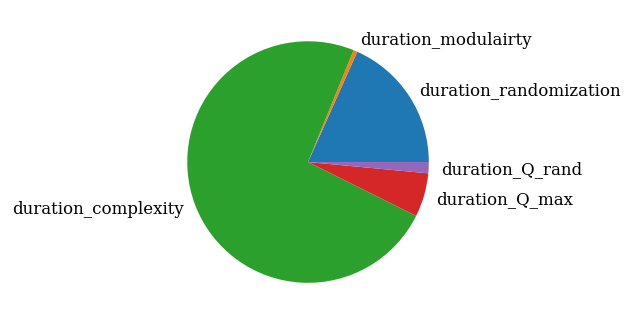

In [116]:
df['duration_rest'] = df['DURATION'] - df['duration_modulairty'] - df['duration_randomization']
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=False, squeeze=False, figsize=(5, 5), dpi=120) 

df[['duration_randomization', 'duration_modulairty', 'duration_complexity', 'duration_Q_max', 'duration_Q_rand']].sum(axis=0).plot.pie(ax=ax[0,0])
ax[0,0].set_ylabel("")
fig.tight_layout()
plt.show() 

In [117]:
# Filter simulations where final value of modularity is not close enought to
# target value.
df = pd.DataFrame(df[(np.abs(df['Q_target'] - df['Q_norm_end']) < 0.05) ])
df = pd.DataFrame(df[(df['num_iterations_modularity'] < 200001) & (df['num_iterations_randomization'] < 200001)])
df_aggr = df.groupby(['c_target', 'Q_target'], as_index=False).mean()

/tmp/ipykernel_11245/3505622403.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_aggr = df.groupby(['c_target', 'Q_target'], as_index=False).mean()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


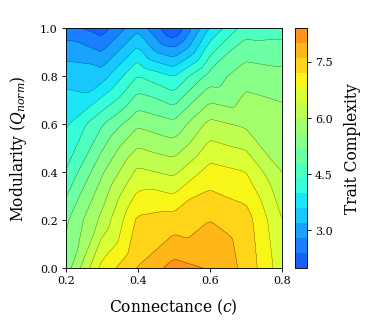

In [118]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=False, squeeze=False, figsize=(STD_PLOT_WIDTH, STD_PLOT_HEIGHT), dpi=DPI_JUPYTER) 
ax = ax[0,0]
axc = countour_plot(df_aggr, 'c_target', 'Q_target', 'avg_rel_complexity_end', ax=ax, ngridx = 50, ngridy = 50, levels=levels)

ax.set(xlim=(0.2, 0.8), ylim=(0.0, 1.0))
axc.set_label("Trait Complexity")
ax.set_xlabel("Connectance ($c$)")
ax.set_ylabel("Modularity ($Q_{norm}$)")
    
ax.set_title(" ", fontsize=16)
fig.tight_layout()

plt.subplots_adjust(left=0.15,
                    bottom=0.15, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.0, 
                    hspace=0.0)

if SAVE_FIGURES:
    fig.savefig(PATH + PLOT_DIR + "Figure_5A." + IMG_FORMAT, dpi=DPI_FILE)
    
plt.show() 

953    2.1
Name: avg_rel_complexity_end, dtype: float64
903    6.75
Name: avg_rel_complexity_end, dtype: float64


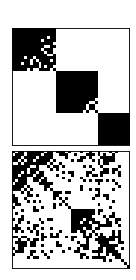

In [119]:
replicate = 3
c = 0.3
net_modular = df[(df['c_target'] == c) & (df['Q_target'] == 1.0) & (df['REPLICATE'] == replicate)]
net_random = df[(df['c_target'] == c) & (df['Q_target'] == 0.0) & (df['REPLICATE'] == replicate)]
print(net_modular['avg_rel_complexity_end'])
print(net_random['avg_rel_complexity_end'])


G_modular = np.loadtxt(StringIO(net_modular['G_end'].iloc[0]), delimiter=" ")
G_rand = np.loadtxt(StringIO(net_random['G_end'].iloc[0]), delimiter=" ")

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=False, squeeze=False, figsize=(1.8, STD_PLOT_HEIGHT), dpi=DPI_JUPYTER)

ax[0,0].dist = 100
G, row_indices, col_indices = sort_matrix_by_modules(G_modular, modularity_function=cacl_modularity_unipartite, return_groups=True)
plot_binary_matrix(G, ax[0, 0])
ax[0,0].set_title(" ", fontsize=16)

G, row_indices, col_indices = sort_matrix_by_modules(G_rand, modularity_function=cacl_modularity_unipartite, return_groups=True)
plot_binary_matrix(G, ax[1, 0])

plt.subplots_adjust(left=0.0,
                    bottom=0.15, 
                    right=1.0, 
                    top=0.9, 
                    wspace=0.0, 
                    hspace=0.05)

if SAVE_FIGURES:
    fig.savefig(PATH + PLOT_DIR + "Figure_5B." + IMG_FORMAT, dpi=DPI_FILE)
    
plt.show()

In [120]:
df_all_N = pd.read_csv(DATA_DIR + "opt_modularity_NN.csv", index_col=0)
print_data_summary(df_all_N)

Details:
Num replicates:  392
N:  [10 20 30 40 50]
n:  [20]
th:  [1.]
FSM_COMPLEXITY_MAX_NO_IMPROVE:  [2000000]
NUM_RANDOMIZATIONS:  [500]
MAX_MODULARITY_MAX_NO_IMPROVEMENT:  [20000]

Total Duration:  37.685 h


In [121]:
print("Parameter Space Scan:")
num_replicates = df_all_N.groupby(['NN', 'n', 'th', 'c_target', 'Q_target']).count()['ID'].iloc[0]
print("Num replicates: ", num_replicates)
print("N: ", df_all_N['NN'].unique())
print("n: ", df_all_N['n'].unique())
print("th: ", df_all_N['th'].unique())
print("c_target: ", df_all_N['c_target'].unique())
print("Q_target: ", df_all_N['Q_target'].unique())
print()
print("Total Duration: ", round(df_all_N['DURATION'].sum() / 48 / 60 / 60, 3), "h")

Parameter Space Scan:
Num replicates:  10
N:  [10 20 30 40 50]
n:  [20]
th:  [1.]
c_target:  [0.2 0.3 0.4 0.5 0.6 0.7 0.8]
Q_target:  [0.  0.2 0.4 0.6 0.8 1. ]

Total Duration:  37.685 h


In [122]:
n = 20
th = 1.0
c = 0.2

df = pd.DataFrame(df_all_N[df_all_N['n'] == n])
df = pd.DataFrame(df[df['th'] == th])
df = pd.DataFrame(df[df['c_target'] == c])
df_aggr = df.groupby(['NN', 'Q_target'], as_index=False).mean()

/tmp/ipykernel_11245/3219915857.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_aggr = df.groupby(['NN', 'Q_target'], as_index=False).mean()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


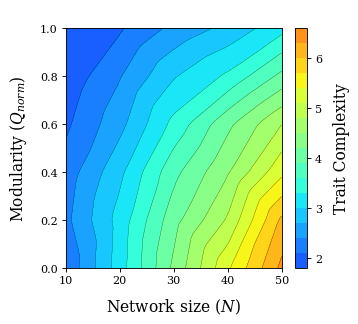

In [123]:
levels = 15

fig, ax = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=False, squeeze=False, figsize=(STD_PLOT_WIDTH, STD_PLOT_HEIGHT), dpi=DPI_JUPYTER) 
ax = ax[0,0]

axc = countour_plot(df_aggr, 'NN', 'Q_target', 'avg_rel_complexity_end', levels, ax, ngridx = 50, ngridy = 50)

ax.set(xlim=(10, 50), ylim=(0.0, 1.0))

axc.set_label("Trait Complexity")
ax.set_xlabel("Network size ($N$)")
ax.set_ylabel("Modularity ($Q_{norm}$)")

ax.set_title(" ", fontsize=16)
fig.tight_layout()
plt.subplots_adjust(left=0.15,
                    bottom=0.15, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.0, 
                    hspace=0.0)

if SAVE_FIGURES:
    fig.savefig(PATH + PLOT_DIR + "Figure_5C." + IMG_FORMAT, dpi=DPI_FILE)
    
plt.show() 

## Figure S9

/tmp/ipykernel_11245/4092184684.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_aggr = df.groupby(['c_target', 'Q_target'], as_index=False).mean()
/tmp/ipykernel_11245/4092184684.py:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_aggr = df.groupby(['c_target', 'Q_target'], as_index=False).mean()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


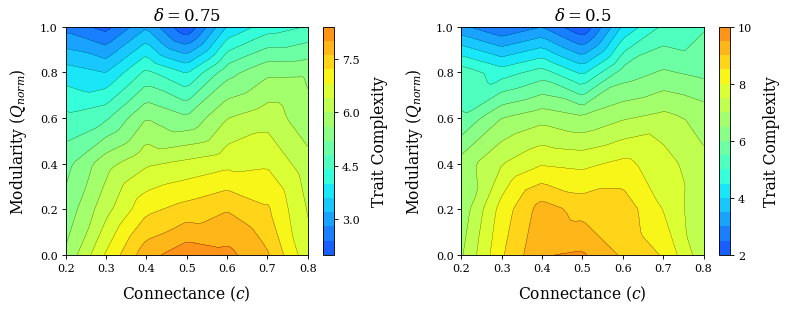

In [124]:
th = 0.75
df = pd.DataFrame(df_all[df_all['NN'] == N])
df = pd.DataFrame(df[df['n'] == n])
df = pd.DataFrame(df[df['th'] == th])
df_aggr = df.groupby(['c_target', 'Q_target'], as_index=False).mean()

fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, squeeze=False, figsize=(10, STD_PLOT_HEIGHT), dpi=DPI_JUPYTER) 

axc = countour_plot(df_aggr, 'c_target', 'Q_target', 'avg_rel_complexity_end', levels, ax[0,0], ngridx = 50, ngridy = 50)

ax[0,0].set(xlim=(0.2, 0.8), ylim=(0.0, 1.0))
axc.set_label("Trait Complexity")
ax[0,0].set_xlabel("Connectance ($c$)")
ax[0,0].set_ylabel("Modularity ($Q_{norm}$)")
ax[0,0].set_title("$\delta = 0.75$", fontsize=15)

th = 0.5
df = pd.DataFrame(df_all[df_all['NN'] == N])
df = pd.DataFrame(df[df['n'] == n])
df = pd.DataFrame(df[df['th'] == th])
df_aggr = df.groupby(['c_target', 'Q_target'], as_index=False).mean()

axc = countour_plot(df_aggr, 'c_target', 'Q_target', 'avg_rel_complexity_end', levels, ax[0,1], ngridx = 50, ngridy = 50)

ax[0,1].set(xlim=(0.2, 0.8), ylim=(0.0, 1.0))
axc.set_label("Trait Complexity")
ax[0,1].set_xlabel("Connectance ($c$)")
ax[0,1].set_ylabel("Modularity ($Q_{norm}$)")
ax[0,1].set_title("$\delta = 0.5$", fontsize=15)

fig.tight_layout()

if SAVE_FIGURES:
    fig.savefig(PATH + SUPPLEMENT_PLOT_DIR + "ESM_unipartite_trait_complexity_vs_Q_and_c_th." + IMG_FORMAT, dpi=DPI_FILE)
    
plt.show() 

## Figure S10

In [125]:
N_ = [10, 20, 30, 40, 50, 60]
c_ = [0.2, 0.5, 0.8]
num_replicates = 40

In [126]:

df_I = pd.DataFrame(columns=['c', 'N', 'I', 'replicate'])

for N in N_:
    for c in c_:
        L = int(c * ((N ** 2) - N) / 2)
        for r in range(num_replicates):
            G_rand = get_ER_graph(N, L)
            I = mutual_information(G_rand)

            df_I.loc[len(df_I)+1,: ] = {
                        'c' : c,
                        'N' : N,
                        'I' : I,
                        'replicate' : r
                        }

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


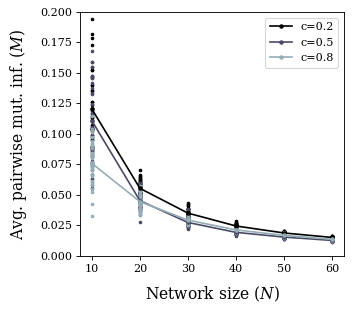

In [127]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=False, squeeze=False, figsize=(STD_PLOT_WIDTH, STD_PLOT_HEIGHT), dpi=DPI_JUPYTER) 

colors = getColorsFromColorMap ('bone', len(c_), min=0.0, max=0.0)

for i, c in enumerate(c_):
    df_tmp = df_I[df_I['c'] == c]
    df_tmp.groupby(['N'], as_index=False).mean().plot(x='N', y='I', ax=ax[0,0], marker='.', label='c=' + str(c), color=colors[i])
    df_tmp.plot.scatter(x='N', y='I', ax=ax[0,0],  marker='.', color=colors[i])

ax[0,0].set_ylabel(r"Avg. pairwise mut. inf. ($M$)")
ax[0,0].set_xlabel("Network size ($N$)")
ax[0,0].set_ylim(0, 0.2)
fig.tight_layout()

if SAVE_FIGURES:
    fig.savefig(PATH + SUPPLEMENT_PLOT_DIR + "ESM_mutual_information_random_vs_c_and_N." + IMG_FORMAT, dpi=DPI_FILE)
    
plt.show() 

<br>

# Experiment: Sampling phenotype space

<br>

## Figure 6 - Phenotype frequency distribution

In [128]:
d = "/genotype_phenotype/"
df_phenotypes = pd.read_csv(DATA_DIR + d + 'phenotypes.csv', index_col=0, dtype={'phenotype': str})

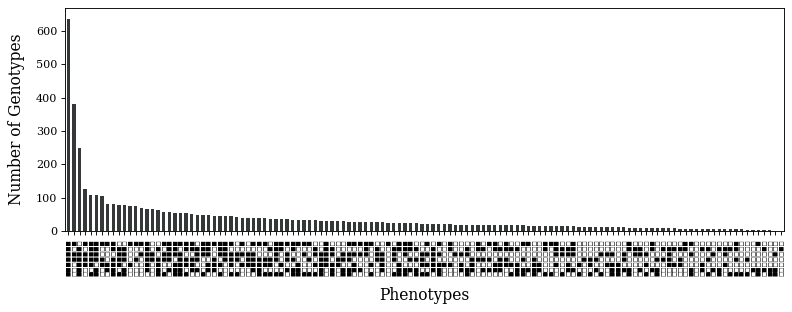

In [129]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=False, squeeze=False, figsize=(10, STD_PLOT_HEIGHT), dpi=DPI_JUPYTER)

df_phenotypes = df_phenotypes.sort_values(['count'], ascending=False)

df_phenotypes['phenotype_label'] = df_phenotypes['phenotype'].map(lambda x: x.replace('1', '■').replace('0', '□')[::-1])
df_phenotypes[['phenotype_label',  'count']].plot(x='phenotype_label', kind='bar', ax=ax[0,0], width=0.6, stacked=True, logy=False, color='#343838')

ax[0,0].tick_params(axis='x', which='both', labelsize=5.0)

ax[0,0].get_legend().remove()
ax[0,0].set_xlabel("Phenotypes")
ax[0,0].set_ylabel("Number of Genotypes")
fig.tight_layout()

if SAVE_FIGURES:
    fig.savefig(PATH + PLOT_DIR + f"Figure_6." + IMG_FORMAT, dpi=DPI_FILE)

plt.show()

In [130]:
len(df_phenotypes)

128

In [131]:
df_times = pd.read_csv(DATA_DIR + d + 'discovery_times.csv', index_col=0)

<AxesSubplot:xlabel='sample_number'>

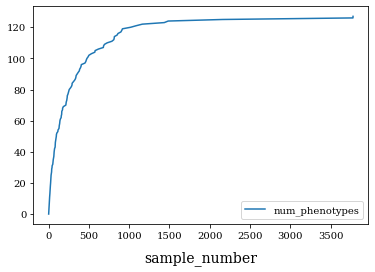

In [132]:
df_times.plot(x='sample_number', y='num_phenotypes')

In [133]:
df_phenotypes['count'].sum()

5001

## Figure S12 and S13



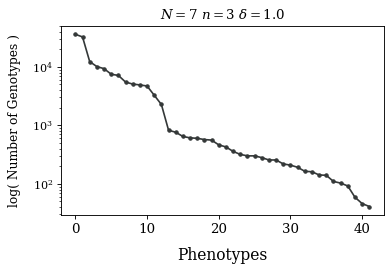

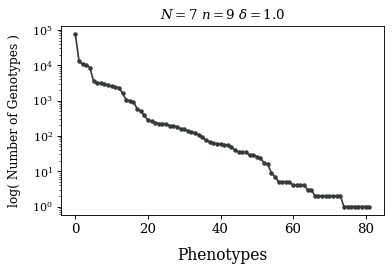

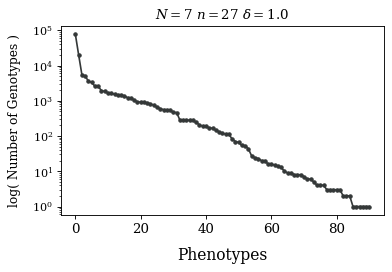

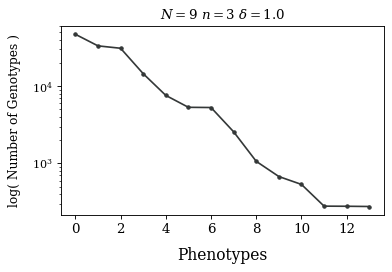

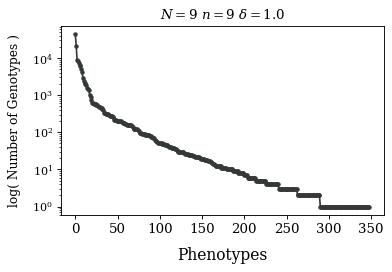

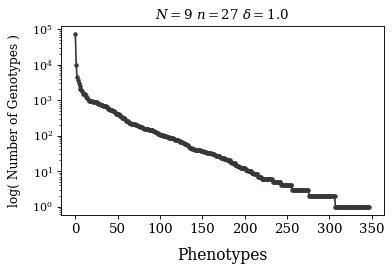

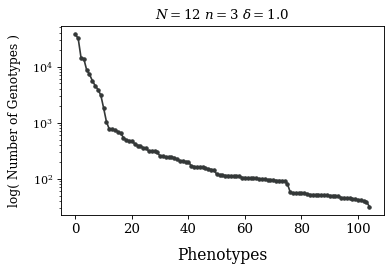

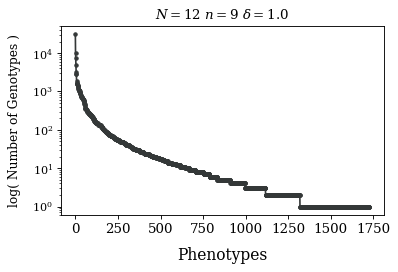

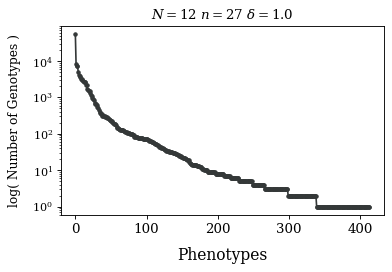

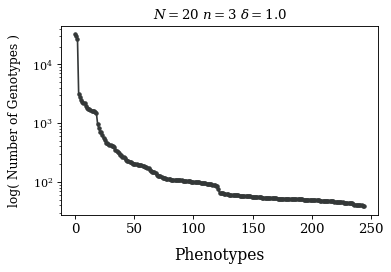

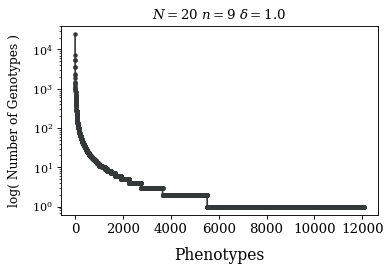

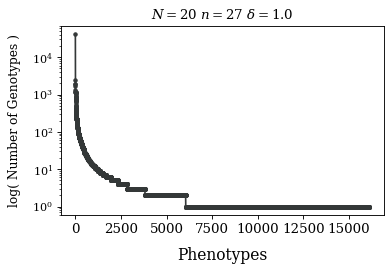

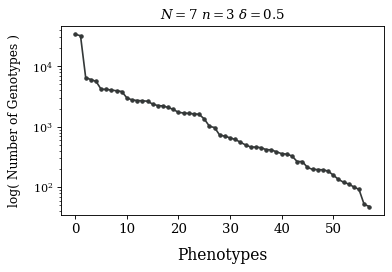

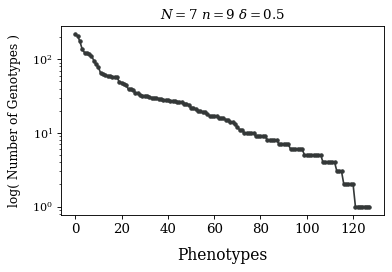

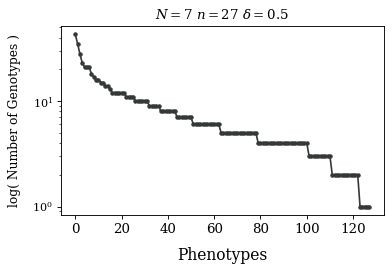

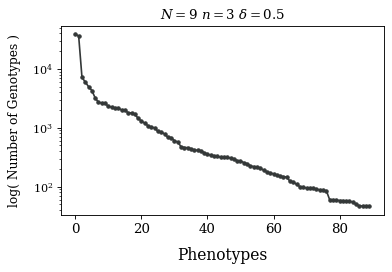

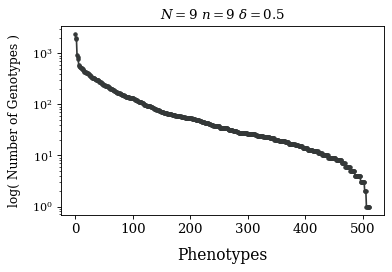

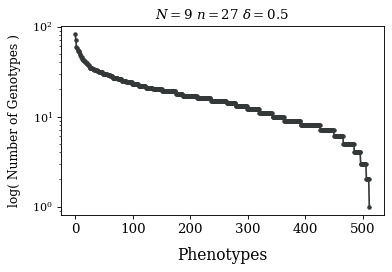

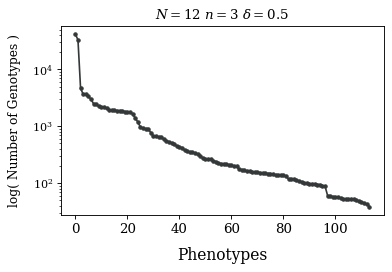

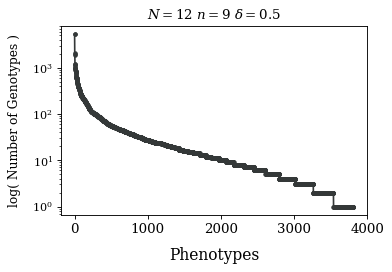

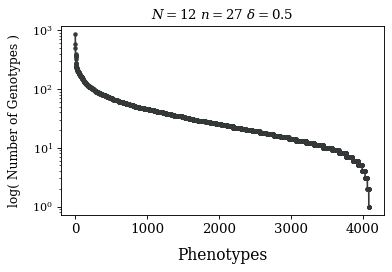

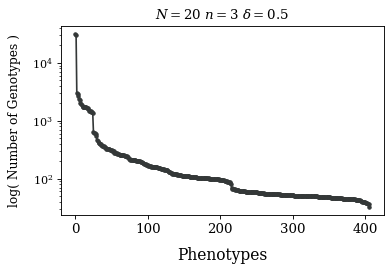

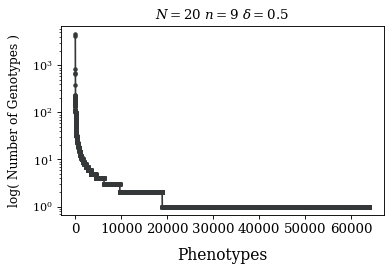

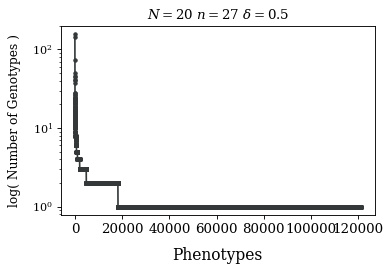

In [134]:
N_ = [12, 20]
n_ = [3, 9, 27]
th_ = ['1', '05']
delta_ = {'1': 1.0, '05': 0.5}

for th in th_:
    for N in N_:
        for n in n_:
            name = f'N{N}_n{n}_150000'

            d = "/genotype_phenotype/th" + th + "/" + name + "/"

            df_phenotypes = pd.read_csv(DATA_DIR + d + 'phenotypes.csv', index_col=0, dtype={'phenotype': str})

            fig, ax = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=False, squeeze=False, figsize=(5, 3.5), dpi=DPI_JUPYTER)

            df_phenotypes = df_phenotypes.sort_values(['count'], ascending=False)

            if False:
                df_phenotypes['phenotype_label'] = df_phenotypes['phenotype'].map(lambda x: x.replace('1', '■').replace('0', '□')[::-1])
                df_phenotypes[['phenotype_label',  'count']].plot(x='phenotype_label', kind='bar', ax=ax[0,0], width=0.6, stacked=True, logy=True, color='#343838')
            else:
                df_phenotypes['phenotype_label'] = range(len(df_phenotypes['phenotype']))
                df_phenotypes[['phenotype_label',  'count']].plot(x='phenotype_label', y='count', kind='line', ax=ax[0,0], logx=False, logy=True, color='#343838', marker='.')

            ax[0,0].tick_params(axis='x', which='both', labelsize=12.0)
            ax[0,0].get_legend().remove()
            ax[0,0].set_xlabel("Phenotypes")
            ax[0,0].set_ylabel("log( Number of Genotypes )", fontsize=11)
            ax[0,0].set_title(f"$N={N}$ $n={n}$ $\delta={delta_[th]}$")
            fig.tight_layout()

            if SAVE_FIGURES:
                fig.savefig(PATH + SUPPLEMENT_PLOT_DIR + f"ESM_phenotype_frequency_distribution_N{N}_n{n}_delta{th}." + IMG_FORMAT, dpi=DPI_FILE)

            plt.show()


<br>

# Additional Analyses

<br>

## Figure S11

Analysis of the degree distributions shown in the supplementary material (S4.1).

In [153]:
N = 2000
n_ = [10, 30, 50]
th_ = [0.5, 0.75, 1.0]

# Comment this:
N = 50

In [136]:

# Slow
df_degrees = pd.DataFrame(columns=['n', 'th', 'degree'])

for th in th_:
    for n in n_:
        print(n, th)
        population = get_random_population(N, n, alphabet=['0', '1'])
        A = compute_G(population, th=th)

        rows = dict()
        rows['degree'] = list(A.sum(axis=1))
        rows['n'] = [n] * N
        rows['th'] = [th] * N
        
        df_degrees = pd.concat([df_degrees, pd.DataFrame(rows)])
        

10 0.5
30 0.5
50 0.5
10 0.75
30 0.75
50 0.75
10 1.0
30 1.0
50 1.0


In [137]:
df_degrees['degree_norm'] = (df_degrees['degree']-1) / (N-1)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


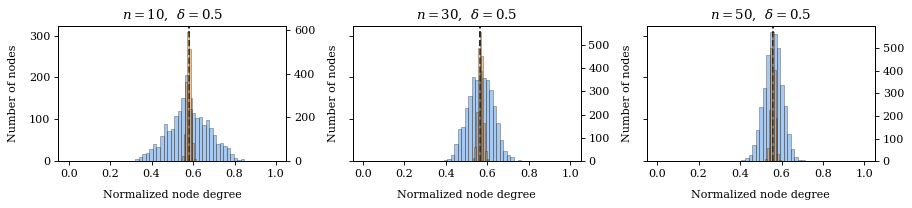

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


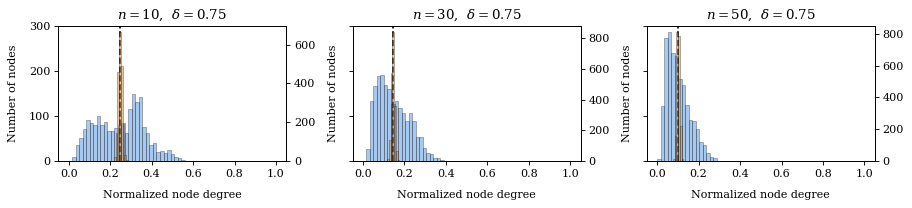

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


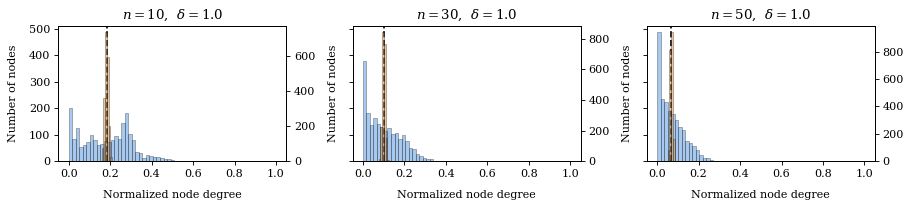

In [138]:
ASSEMBLAGE_COLOR = '#5395e0'
RANDOM_COLOR = '#cf8f48'

for th in th_:
    
    fig, ax = plt.subplots(nrows=1, ncols=3, squeeze=False, sharey=True, figsize=(11.5, 2.7), dpi=DPI_JUPYTER)
    
    for col, n in enumerate(n_):
        
        df_tmp = df_degrees[(df_degrees['n'] == n) & (df_degrees['th'] == th)]
        norm_degrees = df_tmp['degree_norm']
        degrees = df_tmp['degree'] - 1
        
        # Compute degree distribution of ER network of same size and connectance
        c = np.sum(degrees) / (N**2-N)
        g_ER = igraph.Graph.Erdos_Renyi(n=N, p=c, directed=False, loops=False)
        ER_norm_degrees = np.array(g_ER.degree()) / N
        ax2 = ax[0,col].twinx()
        ax2.hist(ER_norm_degrees, bins=np.linspace(0, 1, 120), density=False, color=RANDOM_COLOR, alpha=0.5, edgecolor='black', linewidth=0.5)
        
        ax[0,col].hist(norm_degrees, bins=np.linspace(0, 1, 60), density=False, color=ASSEMBLAGE_COLOR, alpha=0.5, edgecolor='black', linewidth=0.5)
        ax[0,col].axvline(np.mean(norm_degrees), linestyle='--', color='black')
        ax[0,col].set_title(f'$n={n}$,  $\delta={th}$', fontsize=12)
        ax[0,col].set_xlabel('Normalized node degree', fontsize=10)
        ax[0,col].set_ylabel('Number of nodes', fontsize=10)


    fig.tight_layout()
    
    if SAVE_FIGURES:
        fig.savefig(PATH + SUPPLEMENT_PLOT_DIR + f"ESM_degree_{th}." + IMG_FORMAT, dpi=DPI_FILE)

    plt.show()

## Tables S1, S2, S3

Visualization of the cylces of a population of $N=5$ FSM.

In [139]:
def get_table(cycles, pins=None, f='grid'):
    data = []
    for i in range(N):
        row = []
        for j in range(0, N): 
            if pins is None:
                row.append(cycles[i][j] + '\n' + cycles[j][i])
            else:
                row.append(pins[i][j] + '|' + cycles[i][j] + '\n' + pins[j][i] + '|' + cycles[j][i])
        data.append(row)

    table = tabulate.tabulate(data, tablefmt=f)
    return table

In [140]:
def compute_fsm_graph(fsm):
    
    g = igraph.Graph(directed=True)
    g.add_vertices(fsm.n)
    edges = []
    edge_labels = []
    node_labels = [None] * fsm.n
    
    for state in range(fsm.n):
     
        state_index = state * (1+fsm.alphabet_size)
        out_symbol = fsm.genome[state_index]
        for edge in range(fsm.alphabet_size):
            edges.append((state, fsm.genome[state_index+1+edge]))
            edge_labels.append(str(edge))
        
        node_labels[state] = out_symbol
        
    g.add_edges(edges)

    return g, edge_labels, node_labels

In [141]:
def plot_graph(fsm, target):

    g, edge_lables, node_labels = compute_fsm_graph(fsm)
    colors = {'1': '#856622', '0': '#1f6682'}
    colors_nodes = {'1': '#deb354', '0': '#54c0eb'}
    
    edge_colors = [colors[l] for l in edge_lables]
    vertex_colors = [colors_nodes[l] for l in node_labels]

    igraph.plot(g, 
                bbox=(0, 0, 600, 600), 
                margin=100,
                vertex_size=70, 
                vertex_label=node_labels, 
                vertex_label_dist=-0.0,
                vertex_color=vertex_colors, 
                vertex_label_size=20, 
                vertex_frame_width=[4.0]+[2.0]*(fsm.n-1),
                edge_width=2.8,
                edge_arrow_size=1.5, 
                layout='circular', 
                dpi=500,
                #edge_label=edge_lables,
                edge_color=edge_colors,
                edge_label_size=15,
                edge_label_dist=0,
                background=(0,0,0,0),
                target=target)


In [142]:
rng = np.random.default_rng(11111)
rng_w = RandomWrapper(rng)

In [143]:
N = 5
n = 10
th = 1.0
FSM_COMPLEXITY_MAX_NO_IMPROVE = 20000

In [144]:
############################################
# Sample Population
############################################
population = get_random_population(N, n, alphabet=['0', '1'], random_generator=rng_w)
A, cycles, pins = compute_G(population, th=th, return_cycles=True, return_pins=True)

In [145]:
t = get_table(cycles)
print(t)

+-----+-----+-------------+--------+-------------+
| 1   | 1   | 111         | 111    | 111         |
| 1   | 1   | 011         | 011    | 111         |
+-----+-----+-------------+--------+-------------+
| 1   | 0   | 111         | 111    | 1           |
| 1   | 0   | 101         | 110    | 1           |
+-----+-----+-------------+--------+-------------+
| 011 | 101 | 1110        | 011110 | 10110111011 |
| 111 | 111 | 1110        | 010110 | 11111011101 |
+-----+-----+-------------+--------+-------------+
| 011 | 110 | 010110      | 101    | 01011       |
| 111 | 111 | 011110      | 101    | 10111       |
+-----+-----+-------------+--------+-------------+
| 111 | 1   | 11111011101 | 10111  | 111         |
| 111 | 1   | 10110111011 | 01011  | 111         |
+-----+-----+-------------+--------+-------------+


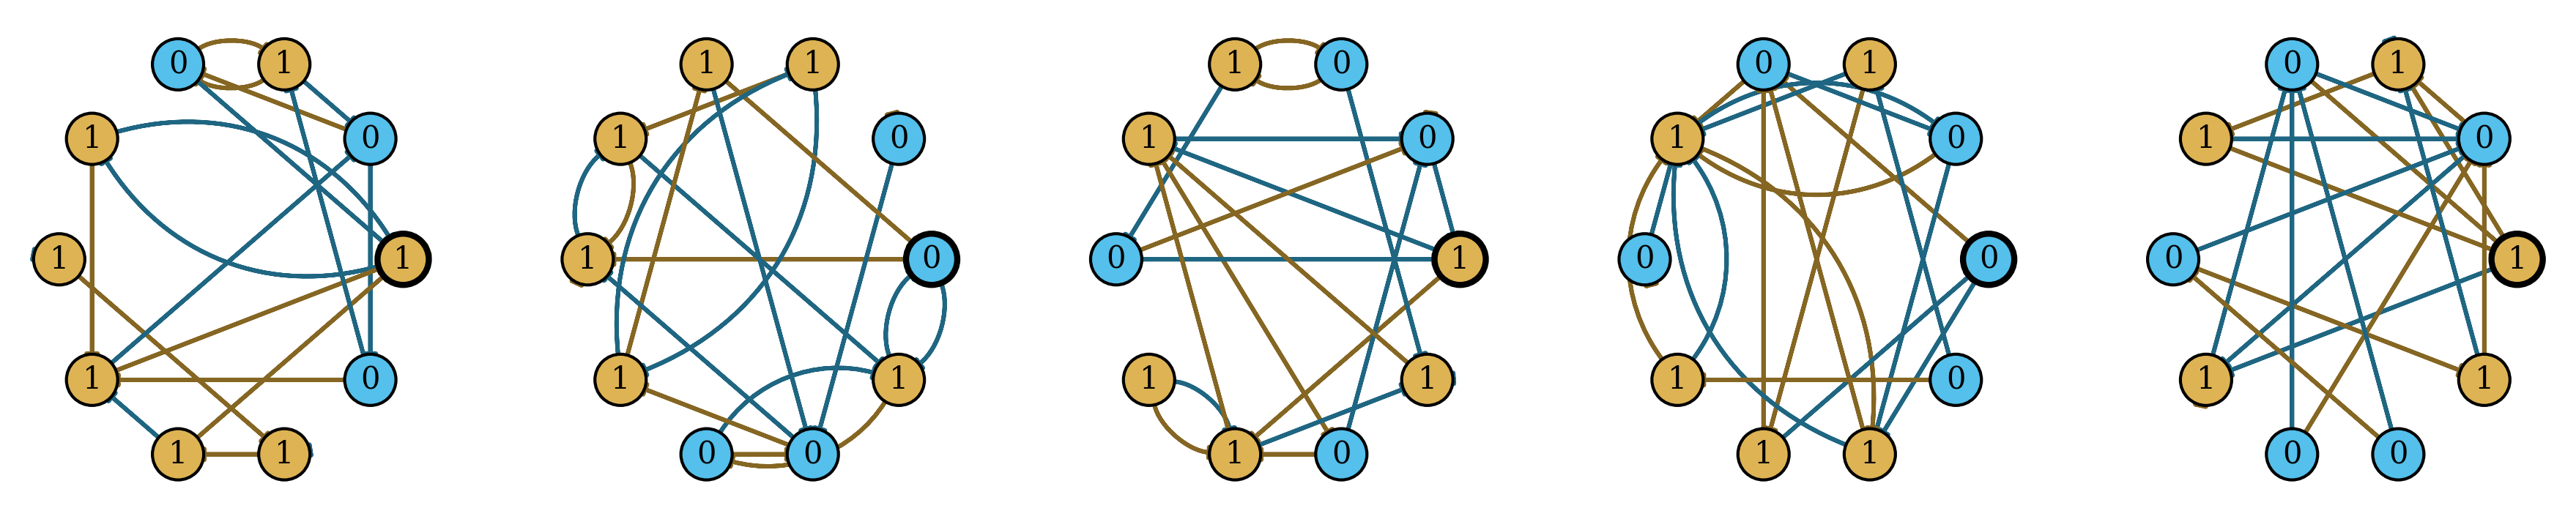

In [146]:
fig, ax = plt.subplots(nrows=1, ncols=N, sharex=False, sharey=False, squeeze=False, figsize=(30, 6), dpi=150)

for i, fsm in enumerate(population):
    plot_graph(fsm, ax[0,i])
    
plt.show()

In [147]:
############################################
# Minimize Absolute
############################################
population_min_abs = [fsm.minimize() for fsm in population]
A, cycles_min_abs, pins = compute_G(population_min_abs, th=th, return_cycles=True, return_pins=True)

In [148]:
print(get_table(cycles_min_abs))

+-----+-----+-------------+--------+-------------+
| 1   | 1   | 111         | 111    | 111         |
| 1   | 1   | 011         | 011    | 111         |
+-----+-----+-------------+--------+-------------+
| 1   | 0   | 111         | 111    | 1           |
| 1   | 0   | 101         | 110    | 1           |
+-----+-----+-------------+--------+-------------+
| 011 | 101 | 1110        | 011110 | 11011011101 |
| 111 | 111 | 1110        | 010110 | 11111101110 |
+-----+-----+-------------+--------+-------------+
| 011 | 110 | 010110      | 101    | 01011       |
| 111 | 111 | 011110      | 101    | 10111       |
+-----+-----+-------------+--------+-------------+
| 111 | 1   | 11111101110 | 10111  | 111         |
| 111 | 1   | 11011011101 | 01011  | 111         |
+-----+-----+-------------+--------+-------------+


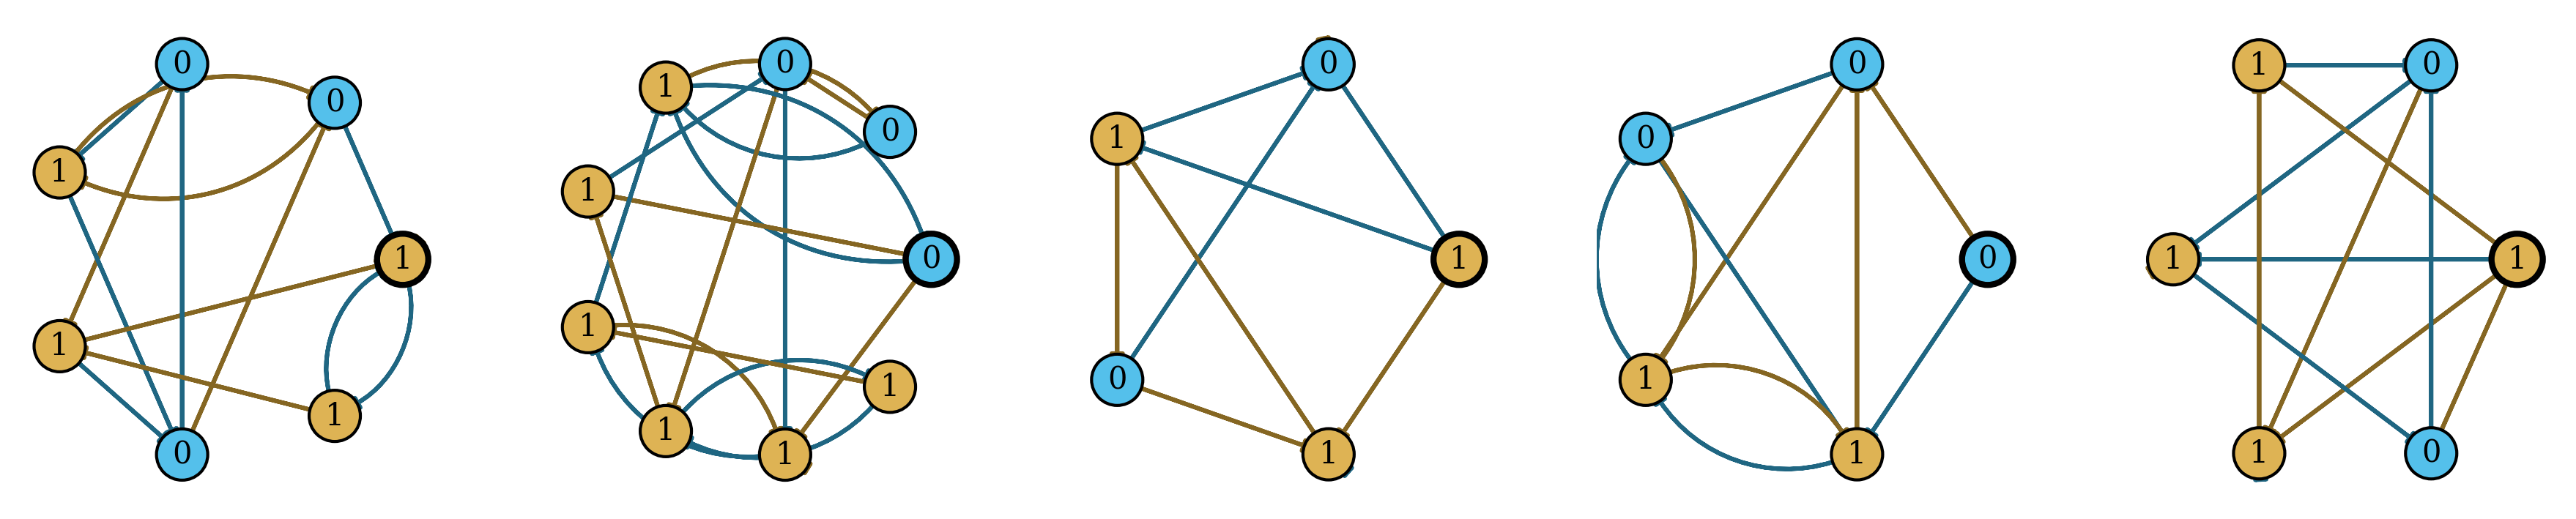

In [149]:
fig, ax = plt.subplots(nrows=1, ncols=N, sharex=False, sharey=False, squeeze=False, figsize=(30, 6), dpi=150)

for i, fsm in enumerate(population_min_abs):
    plot_graph(fsm, ax[0,i])
    
plt.show()

In [150]:
############################################
# Minimize Relative
############################################
avg_complexity, minimizer = minimize_fsm(population, th=th, MAX_NO_IMPROVEMENT=FSM_COMPLEXITY_MAX_NO_IMPROVE, return_minimizer=True)
population_min_rel = minimizer.fsm_

A, cycles_min, pins = compute_G(population_min_rel, th=th, return_cycles=True, return_pins=True)

In [151]:
print(get_table(cycles_min))

+---+---+----+----+---+
| 1 | 1 | 1  | 1  | 1 |
| 1 | 1 | 0  | 0  | 1 |
+---+---+----+----+---+
| 1 | 1 | 1  | 1  | 1 |
| 1 | 1 | 0  | 0  | 1 |
+---+---+----+----+---+
| 0 | 0 | 0  | 00 | 0 |
| 1 | 1 | 0  | 01 | 1 |
+---+---+----+----+---+
| 0 | 0 | 01 | 0  | 0 |
| 1 | 1 | 00 | 0  | 1 |
+---+---+----+----+---+
| 1 | 1 | 1  | 1  | 1 |
| 1 | 1 | 0  | 0  | 1 |
+---+---+----+----+---+


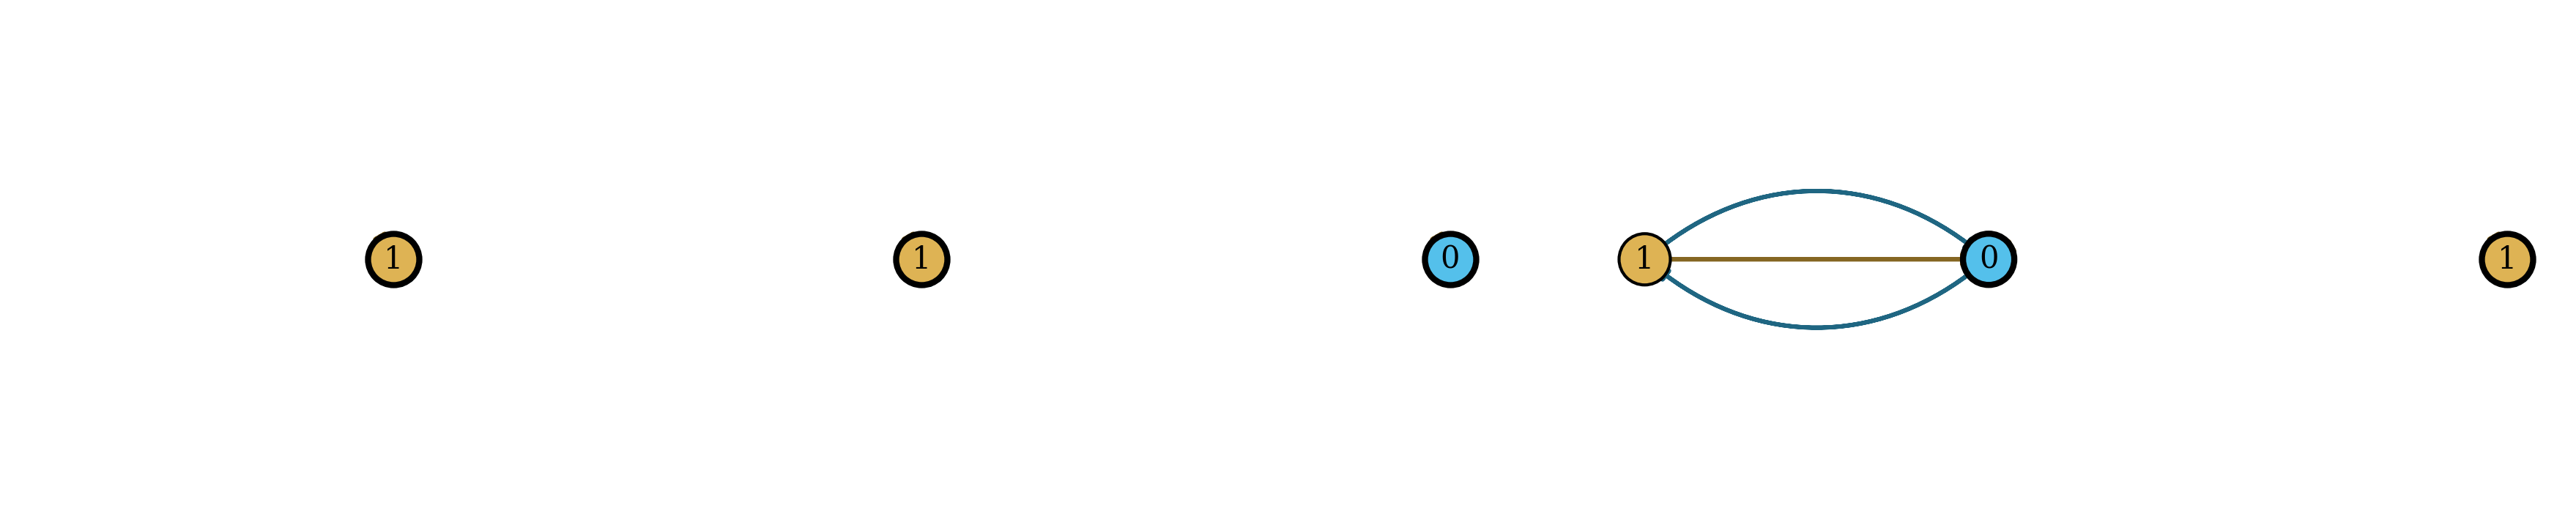

In [152]:
fig, ax = plt.subplots(nrows=1, ncols=N, sharex=False, sharey=False, squeeze=False, figsize=(30, 6), dpi=150)

for i, fsm in enumerate(population_min_rel):
    plot_graph(fsm, ax[0,i])
    
plt.show()